In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPool2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing \
import RandomFlip,RandomRotation,Rescaling,RandomContrast


#### Import the data into the dataframes : 
    - Set the size and shape of the images so that it's ready for preprocessing
    
Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).    
more info -https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [2]:
train_df = image_dataset_from_directory('Resources/Train',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       
                                       )

valid_df = image_dataset_from_directory('Resources//Validation',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       
                                       )

test_df = image_dataset_from_directory('Resources/Test',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


### tf.data.AUTOTUNE:
tf.data.AUTOTUNE:The tf.data API helps to build flexible and efficient input pipelines,Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished.
data AUTOTUNE. prefetch transformation, which can be used to decouple the time when data is produced from the time when data is consumed. 
builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE. 

More INfo - https://www.coursera.org/lecture/data-pipelines-tensorflow/autotuning-zHRuK

#### Autotune all the dataframes

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

#### Building the CNN Model from Scratch

A Convolutional Neural Network (CNN) is a Deep Learning algorithm used specifically for images. Algorithm identifies patterns within the image, assigning importance to different patterns/objects in an image, using weights and biases to recognize differences and similarities amongst input images. These CNNs are trained based on labeled images. The job of a CNN is to decrease the pictures into a structure which is simpler to process, without losing weights/bias which are essential tp getting a the best results.

Here we will build the layers to our Convolutional Neural Network. We will start by adding a sequential layer; followed by our 2D convolutional layers, Max pooling layers, Dense layers, and Dropout layers.


More info : https://towardsdatascience.com/building-a-convolutional-neural-network-to-recognize-shaved-vs-unshaved-faces-cb96ea5bc0f0

In [4]:
model = Sequential([
    Rescaling(1.0/255,input_shape=(128,128,3)),
    RandomFlip(),
    RandomRotation(0.4),
    RandomContrast(0.3),
    
    # First Layer
    layers.Conv2D(filters=20, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Second Layer
    layers.Conv2D(filters=20, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Third Layer
    layers.Conv2D(filters=20, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Forth Layer
    layers.Conv2D(filters=20, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Fivth Layer
    layers.Conv2D(filters=20, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6,activation='relu'),
    layers.Dense(units=1,activation='sigmoid')
    
])

# timing the training
import time
start_time = time.time()


# compile the model

model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.02),
    loss='binary_crossentropy', 
    metrics=['binary_accuracy'],
)

In [5]:
# fitting the model to train/test data
history = model.fit(train_df,
                   validation_data=valid_df,
                   epochs=47,
                   batch_size=32,
                   )

Epoch 1/47
313/313 [==============================] - 145s 458ms/step - loss: 0.4924 - binary_accuracy: 0.7595 - val_loss: 0.4111 - val_binary_accuracy: 0.8325
Epoch 2/47
313/313 [==============================] - 153s 489ms/step - loss: 0.3096 - binary_accuracy: 0.8784 - val_loss: 0.3917 - val_binary_accuracy: 0.8487
Epoch 3/47
313/313 [==============================] - 174s 556ms/step - loss: 0.2913 - binary_accuracy: 0.8870 - val_loss: 0.3570 - val_binary_accuracy: 0.8650
Epoch 4/47
313/313 [==============================] - 174s 557ms/step - loss: 0.2660 - binary_accuracy: 0.8975 - val_loss: 0.3136 - val_binary_accuracy: 0.8763
Epoch 5/47
313/313 [==============================] - 191s 612ms/step - loss: 0.2488 - binary_accuracy: 0.9004 - val_loss: 0.3558 - val_binary_accuracy: 0.8675
Epoch 6/47
313/313 [==============================] - 177s 564ms/step - loss: 0.2295 - binary_accuracy: 0.9137 - val_loss: 0.2946 - val_binary_accuracy: 0.8850
Epoch 7/47
313/313 [====================

<AxesSubplot:>

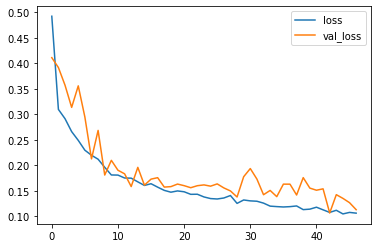

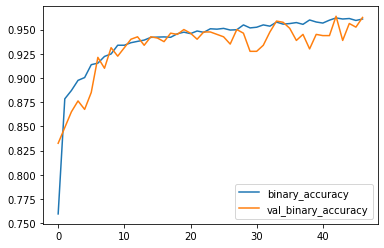

In [6]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['binary_accuracy','val_binary_accuracy']].plot()

In [7]:
# save the model to disk
print("saving mask detector model...")
model.save("./Saved_Model/CNN_model.h5")
#model.save("./model-010.h5")

saving mask detector model...


In [8]:
import cv2
face_model = cv2.CascadeClassifier('./Resources/haarcascade_frontalface_default.xml')

img = cv2.imread('./Resources/Test/85-with-mask.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


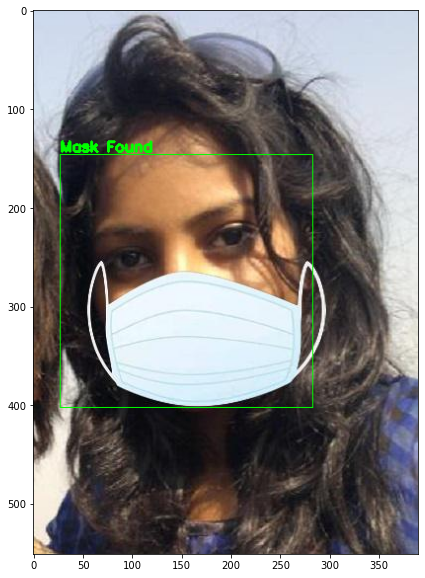

In [10]:
import matplotlib.pyplot as plt
mask_label = {0:'Mask Found',1:'No Mask Found'}
color_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

#check for no. of faces in the image
# if more than one face found,
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    # For every face found, 
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0        
        mask_result = model.predict(crop)
        
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y-3), cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),color_label[label[i]],1)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No image")